# Imports and Initializations

In [1]:
import os
import scipy as sp
import numpy as np
import librosa as lb
import noisereduce as nr
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import time

### Para di magpakita warning message sa mel_spec ###
import warnings
warnings.filterwarnings('ignore')

C:\Users\gbert\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Filepaths

In [2]:
path = "D:\\Aj\\BirdClassification\\NEW DATASET"
wavfiles_path = "D:\\Aj\\BirdClassification\\NEW DATASET\\audio dataset\\original"
# Filepaths for the output spectrograms
spec_path = os.path.join(path, 'FINAL MEL SPEC')
spec_path_orig = os.path.join(spec_path, 'original')
spec_path_timestretch = os.path.join(spec_path, 'timestretch')
spec_path_pitchshift = os.path.join(spec_path, 'pitchshift')
spec_path_noiseinjected = os.path.join(spec_path, 'noiseinjectedFINAL')
spec_path_noisereduced = os.path.join(spec_path, 'noisereduced')
spec_path_horizontalshift = os.path.join(spec_path, 'horizontalshift')

## Parameters

In [3]:
FRAME_SIZE = 2048
HOP_SIZE = 512
SR = 22050
N_MELS = 128
LOWCUT = 1000
HIGHCUT = 11000
DURATION = 5.0

species = os.listdir(wavfiles_path)
species = sorted(species)
print(species, len(species))

['AsianGlossyStarling', 'Black-crownedNightHeron', 'Black-napedOriole', 'Blue-tailedBee-eater', 'BrownShrike', 'ChestnutMunia', 'CollaredKingfisher', 'EurasianTreeSparrow', 'Grey-backedTailorbird', 'GreyWagtail', 'MangroveBlueFlycatcher', 'Olive-backedSunbird', 'PhilippineMagpie-Robin', 'PhilippinePiedFantail', 'PiedBushChat', 'Red-keeledFlowerpecker', 'White-breastedWaterhen', 'Yellow-ventedBulbul', 'ZebraDove'] 19


## Functions

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=6):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
def split_audio(file):
    x = lb.get_duration(filename=file)
    x = np.floor(x)
    splits = int(x // DURATION)
    return splits

In [6]:
def find_frequency(audio):
    w = np.fft.fft(audio)
    freqs = np.fft.fftfreq(len(w))
    idx = np.argmax(np.abs(w))
    freq = freqs[idx]
    freq_in_hertz = abs(freq * SR)
    return freq_in_hertz

In [7]:
def extract_spectrogram_original(file, splits):
    offset = 0
    duration = DURATION * SR
    duration_in_seconds = duration / SR   # This is equal to 5 seconds
    
    if (splits != 0):
    ## Loading the audio into individual 5-second segments and preprocess from there
        for i in range(1, splits+1):
            # save_path = spec_path_orig + '/' + foldername + '/' + filename + '-' + str(i) + '.png' # path for audio files that are not split
            audio, _ = librosa.load(file, offset=offset, duration=DURATION)
            offset += DURATION
            audio = butter_bandpass_filter(audio, LOWCUT, HIGHCUT, SR)
            if np.all(np.isnan(audio) == True) or np.all(audio == 0):
                continue
            
            ## original
            mel = lb.feature.melspectrogram(audio, sr=SR, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=N_MELS)
            log_mel = lb.power_to_db(mel)
            fig = librosa.display.specshow(log_mel, cmap='jet', sr=SR)
            plt.show(fig)
            
def extract_spectrogram_pitchshift(file, splits):
    offset = 0
    duration = DURATION * SR
    duration_in_seconds = duration / SR   # This is equal to 5 seconds
    
    if (splits != 0):
    ## Loading the audio into individual 5-second segments and preprocess from there
        for i in range(1, splits+1):
            audio, _ = librosa.load(file, offset=offset, duration=DURATION)
            offset += DURATION
            audio = butter_bandpass_filter(audio, LOWCUT, HIGHCUT, SR)
            if np.all(np.isnan(audio) == True) or np.all(audio == 0):
                continue
            num_semitones = np.random.normal(1.75, .25, size=None)
            audio_ps = librosa.effects.pitch_shift(audio, sr=SR, n_steps=num_semitones)
            mel = lb.feature.melspectrogram(audio_ps, sr=SR, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=N_MELS)
            log_mel = lb.power_to_db(mel)
            fig = librosa.display.specshow(log_mel, cmap='jet', sr=SR)
            plt.show(fig)
            
def extract_spectrogram_timestretch(file,splits):
    offset = 0
    duration = DURATION * SR
    duration_in_seconds = duration / SR   # This is equal to 5 seconds
    
    if (splits != 0):
    ## Loading the audio into individual 5-second segments and preprocess from there
        for i in range(1, splits+1):
            # save_path = spec_path_orig + '/' + foldername + '/' + filename + '-' + str(i) + '.png' # path for audio files that are not split
            audio, _ = librosa.load(file, offset=offset, duration=DURATION)
            offset += DURATION
            audio = butter_bandpass_filter(audio, LOWCUT, HIGHCUT, SR)
            if np.all(np.isnan(audio) == True) or np.all(audio == 0):
                continue
            time_stretch_rate = np.random.normal(1.5, 0.05, size=None)
            audio_ts = librosa.effects.time_stretch(audio, rate=time_stretch_rate)
            mel = lb.feature.melspectrogram(audio_ts, sr=SR, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=N_MELS)
            log_mel = lb.power_to_db(mel)
            fig = librosa.display.specshow(log_mel, cmap='jet', sr=SR)
            plt.show(fig)

# Original

In [8]:
folder = os.path.join(wavfiles_path, species[1])
os.chdir(folder) # Changing the directory
sample_wav = os.listdir()[0]
splits = split_audio(sample_wav)

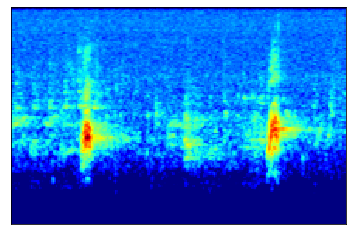

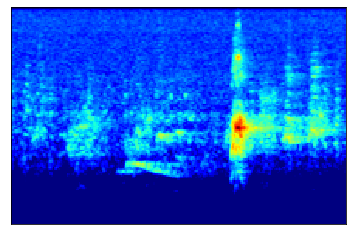

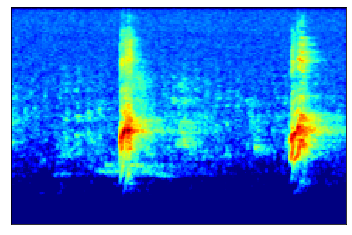

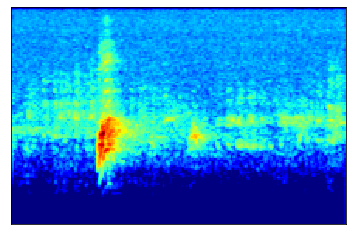

In [9]:
extract_spectrogram_original(sample_wav, splits)

# Pitch Shift

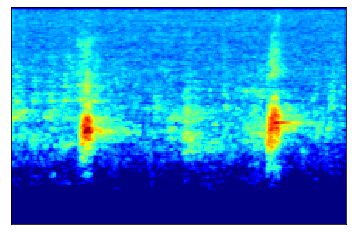

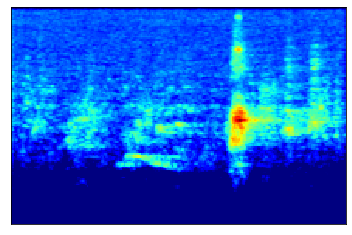

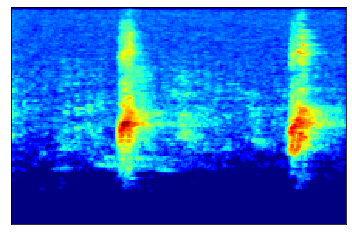

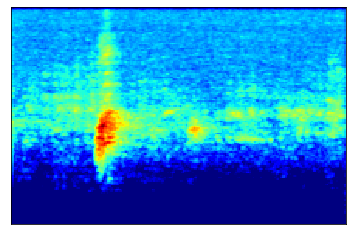

In [10]:
extract_spectrogram_pitchshift(sample_wav, splits)

# Time Stretch

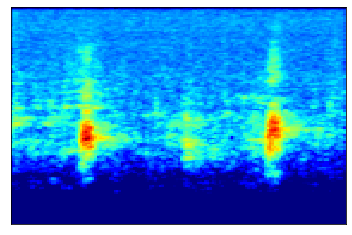

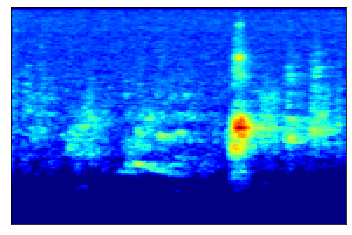

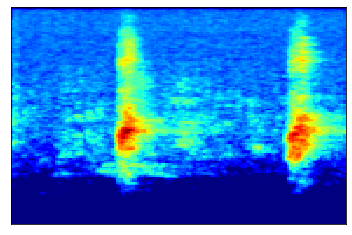

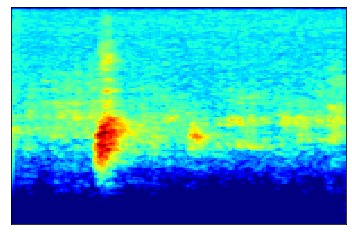

In [11]:
extract_spectrogram_timestretch(sample_wav, splits)